In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import sys
import pandas as pd
import os
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'ecoli.data'), names=['sequence_name', 'mcg', 'gvh', 'lip', 'chg', 
                                                                   'aac', 'alm1', 'alm2', 'class'])

In [3]:
data.drop('sequence_name', axis=1, inplace=True)
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=5)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(201, 7) (67, 7) (68, 7)
(201,) (67,) (68,)


In [4]:
X_scaler = StandardScaler()
y_encoder = LabelEncoder()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_encoder.fit(y_train)
y_train = to_categorical(y_encoder.transform(y_train))
y_val = to_categorical(y_encoder.transform(y_val))
y_test = to_categorical(y_encoder.transform(y_test))

In [5]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.set_title('Final layer values')
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('encrypted')
    ax.set_ylabel('unencrypted')
    ax.plot(np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [7]:
def relu(z):
    return np.maximum(0, z)

In [8]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

In [9]:
weights = np.load('relu_weights.npy')
w1, b1, w2, b2 = weights

In [10]:
layer1_clear = X_test.dot(w1) + b1
layer1_relu_clear = relu(layer1_clear)
layer2_clear = layer1_relu_clear.dot(w2) + b2
pred_clear = softmax(layer2_clear)

In [11]:
pred = np.round(pred_clear.argmax(axis=1).reshape(-1,))
accuracy_score(pred, y_test.argmax(axis=1))

0.8529411764705882

In [12]:
X_test_enc = EA(X_test, to_encrypt=True)
w1_enc = EA(w1)
b1_enc = EA(b1.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [13]:
layer1_enc = X_test_enc.dot(w1_enc) + b1_enc
layer1_relu_enc = layer1_enc.relu()
layer2_enc = layer1_relu_enc.dot(w2_enc) + b2_enc

In [14]:
pred_enc = softmax(layer2_enc.values())

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


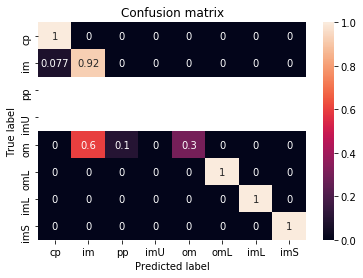

In [16]:
mat = confusion_matrix(pred_enc.argmax(axis=1), y_test.argmax(axis=1), labels=[0, 1, 2, 3, 4, 5, 6, 7])
cm = mat / np.sum(mat, axis=1).reshape(-1, 1)
plot_confusion_matrix(cm, classes=['cp', 'im', 'pp', 'imU', 'om', 'omL', 'imL', 'imS'])

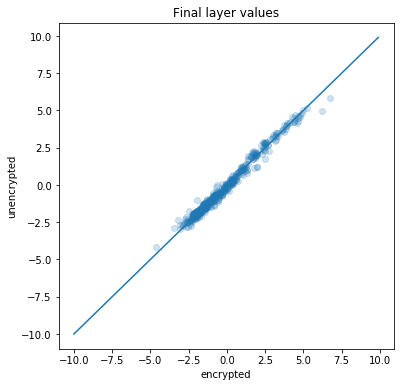

In [17]:
plot_predictions(layer2_enc.values(), layer2_clear)